# Bee Colony Capstone - modeling step, using 3 regression models

## Import modules

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn import model_selection
from sklearn import pipeline
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics
from patsy import dmatrices
from patsy import dmatrix

## Import data

In [103]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

y_train = y_train['LogFinalToStart'].ravel()
y_test = y_test['LogFinalToStart'].ravel()

# This will only be used for the statsmodel formula, prior to indexing removing the unmodified columns
bee_colony_data = pd.read_csv('bees_post_eda.csv')

## Design matrices specification

In [104]:
# naive predictors
X_train_null = np.ones(shape=y_train.shape[0]).reshape(-1, 1)

# Rename the varroa mites column to make it easier to work with
X_train.rename(columns = {'Varroa mites': 'varroa_mites'}, inplace=True)
X_test.rename(columns = {'Varroa mites': 'varroa_mites'}, inplace=True)

# Regions only
X_train_regions = X_train[['region_midwest', 'region_northeast', 'region_south', 'region_west']]
X_test_regions = X_test[['region_midwest', 'region_northeast', 'region_south', 'region_west']]

# Subregions only - breaking the larger regions down further
subregion_cols = [col for col in X_train.columns.values.tolist() if col.startswith("subregion_")]
X_train_subregions = X_train[subregion_cols]
X_test_subregions = X_test[subregion_cols]

# All pest and other causes of colony loss columns
X_train_all_pests = X_train[['varroa_mites', 'Other pests', 'Diseases', 'Pesticides', 'Other', 'Unknown']]
X_test_all_pests = X_test[['varroa_mites', 'Other pests', 'Diseases', 'Pesticides', 'Other', 'Unknown']]

# Varroa mites column plus subregion columns
# I tried to use the subregion_cols variable here, but I couldn't figure out how to make it work with the mite column
X_train_mites_subregions = X_train[['varroa_mites', 'subregion_east north central', 'subregion_east south central',
       'subregion_mid atlantic', 'subregion_mountain', 'subregion_new england',
       'subregion_pacific', 'subregion_south atlantic',
       'subregion_west north central', 'subregion_west south central']]
X_test_mites_subregions = X_test[['varroa_mites', 'subregion_east north central', 'subregion_east south central',
       'subregion_mid atlantic', 'subregion_mountain', 'subregion_new england',
       'subregion_pacific', 'subregion_south atlantic',
       'subregion_west north central', 'subregion_west south central']]

# Varroa mites data with larger regions
X_train_mites_regions = X_train[['varroa_mites', 'region_midwest', 'region_northeast', 'region_south', 'region_west']]
X_test_mites_regions = X_test[['varroa_mites', 'region_midwest', 'region_northeast', 'region_south', 'region_west']]

# Patsy matrices

# Using a negative one to exclude the intercept
patsy = "(region_west + region_midwest + region_northeast + region_south) * (varroa_mites + Pesticides) - 1"
# When I did the encoding or the indexing in the preprocessing step, it stripped out the 
# plain region / state / subregion columns and replaced them with the dummy columns
# So, I went ahead and added the regions together and multiplied them by the varroa mites and pesticides

train_model_matrix = dmatrix(patsy, X_train)
train_model_matrix_names = train_model_matrix.design_info.column_names

test_model_matrix = dmatrix(patsy, X_test)
test_model_matrix_names = test_model_matrix.design_info.column_names
print(test_model_matrix_names)

['region_west', 'region_midwest', 'region_northeast', 'region_south', 'varroa_mites', 'Pesticides', 'region_west:varroa_mites', 'region_west:Pesticides', 'region_midwest:varroa_mites', 'region_midwest:Pesticides', 'region_northeast:varroa_mites', 'region_northeast:Pesticides', 'region_south:varroa_mites', 'region_south:Pesticides']


## Feature coefficients with statsmodels

In [105]:
bee_colony_data.rename(columns = {'Varroa mites': 'varroa_mites', 'Percent lost': 'percent_lost'}, inplace=True)

mod = smf.ols(formula='percent_lost ~ region + subregion + State + year + quarter + varroa_mites + Pesticides + Diseases', data=bee_colony_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           percent_lost   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     8.602
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           2.33e-46
Time:                        18:56:29   Log-Likelihood:                -2807.2
No. Observations:                 878   AIC:                             5712.
Df Residuals:                     829   BIC:                             5946.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Set up cross-validator

In [106]:
cross_validator = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

## Linear ridge regression

#### LRR  - create model object

In [107]:
lr_baseline = linear_model.Ridge(fit_intercept=False, max_iter=500, random_state=42)

lr_w_features = linear_model.Ridge(fit_intercept=True, max_iter=500, random_state=42)

#### LRR - create params object

In [108]:
lr_params = {"model__alpha": np.logspace(start=-10, stop=2, num=40)}

#### LRR - create pipeline

In [109]:
lr_pipeline = pipeline.Pipeline(steps=[("model", lr_baseline)])

lr_pipeline_w_features = pipeline.Pipeline(steps=[("model", lr_w_features)])

#### LRR - create baseline grid

In [110]:
lr_baseline_grid = model_selection.GridSearchCV(
                        estimator=lr_pipeline,
                        param_grid=lr_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

lr_grid_w_features = model_selection.GridSearchCV(
                        estimator=lr_pipeline_w_features,
                        param_grid=lr_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

### Linear Ridge regression - naive model

#### LRR: naive - fit model

In [111]:
start = time.time()
lr_base_mod = lr_baseline_grid.fit(X_train_null, y_train)
end = time.time()

print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.32 seconds


#### LRR: naive - CV score distribution

Elapsed time: 0.01 seconds


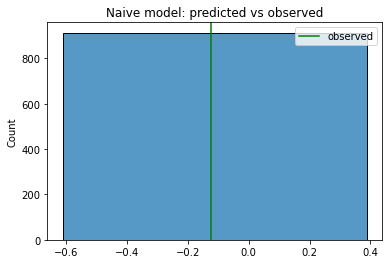

In [112]:
lr_base_best_estimator = lr_base_mod.best_estimator_

# Distribution of cross-validator score
start = time.time()
lr_cv_scores = model_selection.cross_val_score(
                    lr_base_best_estimator,
                    X_train_null,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

# Predict y on training data
y_pred_train_naive = lr_base_best_estimator.predict(X_train_null)
sns.histplot(y_pred_train_naive).set(title='Naive model: predicted vs observed')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: naive - train / test comparison

In [113]:
X_test_null = np.ones(shape=y_test.shape[0]).reshape(-1, 1)

# Predict y on test data
y_pred_test_naive = lr_base_best_estimator.predict(X_test_null)

#### LRR: naive - calculate metrics

In [114]:
print(f"Mean train CV score: {np.mean(lr_cv_scores): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=y_pred_train_naive): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=y_pred_test_naive): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=y_pred_train_naive): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=y_pred_test_naive): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=y_pred_train_naive, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_test_naive, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.050
Test MAE:  0.050
Train R-squared: -0.014
Test R-squared: -0.020
Train RMSE:  0.103
Test RMSE:  0.084


### Linear Ridge regression - with feature data

#### LRR: with features - fit model - predictor: regions

In [115]:
start = time.time()
lr_regions_mod = lr_grid_w_features.fit(X_train_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.66 seconds


#### LRR: with features - CV score distribution - predictor: regions

Elapsed time: 0.02 seconds


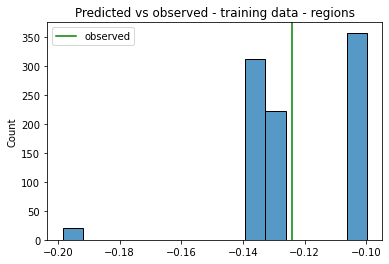

In [116]:
lr_regions_best_estimator = lr_regions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_regions = model_selection.cross_val_score(
                    lr_regions_best_estimator,
                    X_train_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

# Predict y on training data
y_train_lr_pred_regions = lr_regions_best_estimator.predict(X_train_regions)
sns.histplot(y_train_lr_pred_regions).set(title='Predicted vs observed - training data - regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: regions

In [117]:
y_test_lr_pred_regions = lr_regions_best_estimator.predict(X_test_regions)

print(f"Mean train CV score: {np.mean(lr_cv_scores_regions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=y_train_lr_pred_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=y_test_lr_pred_regions): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=y_train_lr_pred_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=y_test_lr_pred_regions): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=y_train_lr_pred_regions, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=y_test_lr_pred_regions, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.049
Test MAE:  0.052
Train R-squared:  0.036
Test R-squared:  0.040
Train RMSE:  0.100
Test RMSE:  0.081


#### LRR: with features - plotting observed vs predicted - predictor: regions

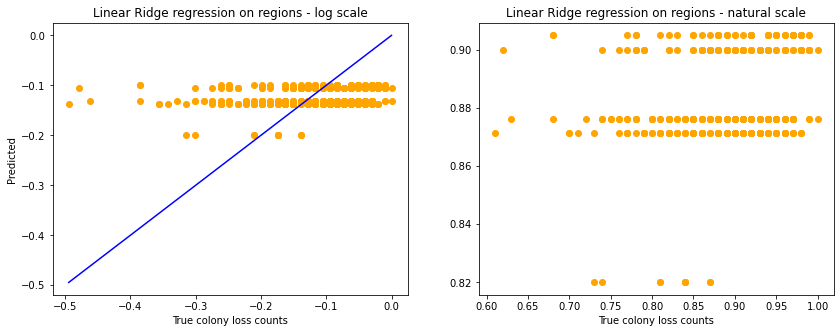

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_test_lr_pred_regions, c="orange")

p1 = max(max(y_test_lr_pred_regions), max(y_test))
p2 = min(min(y_test_lr_pred_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts', ylabel='Predicted', title="Linear Ridge regression on regions - log scale")

ax2.scatter(np.exp(y_test), np.exp(y_test_lr_pred_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Linear Ridge regression on regions - natural scale")

plt.show()

#### Performance

The linear ridge regression on just region data performs only slightly better than the naive model. 

#### LRR: with features - fit model - predictor: subregions

In [119]:
start = time.time()
lr_subregions = lr_grid_w_features.fit(X_train_subregions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.73 seconds


#### LRR: with features - CV score distribution - predictor: subregions

Elapsed time: 0.03 seconds


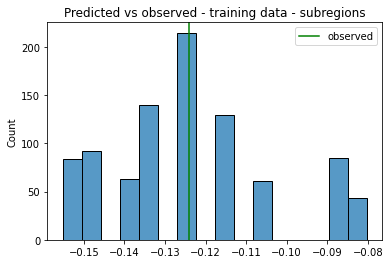

In [120]:
lr_subregions_best_estimator = lr_subregions.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_subregions = model_selection.cross_val_score(
                    lr_subregions_best_estimator,
                    X_train_subregions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_subregions = lr_subregions_best_estimator.predict(X_train_subregions)
sns.histplot(lr_train_pred_subregions).set(title='Predicted vs observed - training data - subregions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: subregions

In [121]:
lr_subregions_test_pred = lr_subregions_best_estimator.predict(X_test_subregions)

print(f"Mean train CV score: {np.mean(lr_cv_scores_subregions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=lr_train_pred_subregions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_subregions_test_pred): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=lr_train_pred_subregions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_subregions_test_pred): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=lr_train_pred_subregions, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_subregions_test_pred, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.052
Test MAE:  0.052
Train R-squared:  0.057
Test R-squared:  0.082
Train RMSE:  0.099
Test RMSE:  0.080


#### LRR: with features - plotting observed vs predicted - predictor: subregions

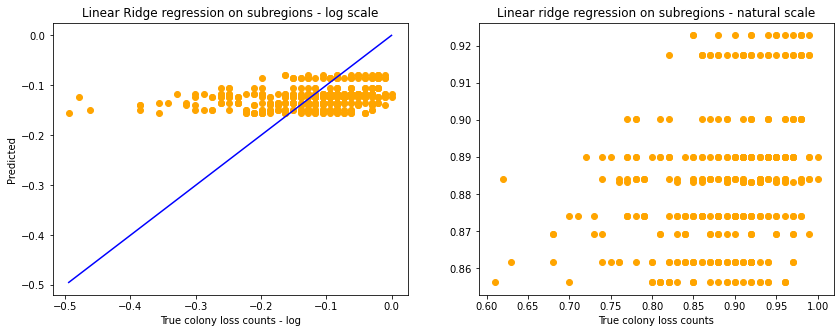

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, lr_subregions_test_pred, c="orange")

p1 = max(max(lr_subregions_test_pred), max(y_test))
p2 = min(min(lr_subregions_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge regression on subregions - log scale")

ax2.scatter(np.exp(y_test), np.exp(lr_subregions_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Linear ridge regression on subregions - natural scale')

plt.show()

#### LRR: with features - performance - predictor: subregions

Linear ridge regression on subregion data has mixed performance, as compared to the baseline. The model was originally optimized for mean absolute error, which performs worse than the naive model. However, the R-squared is considerably better than the naive model, and the RMSE is marginally better. Test and train results for MAE are equal, indicating that the model is an accurate predictor.

#### LRR: with features - fit model - predictor: pests

In [123]:
start = time.time()
lr_all_pests_mod = lr_grid_w_features.fit(X_train_all_pests, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.99 seconds


#### LRR: with features - CV score distribution - predictor: pests

Elapsed time: 0.07 seconds


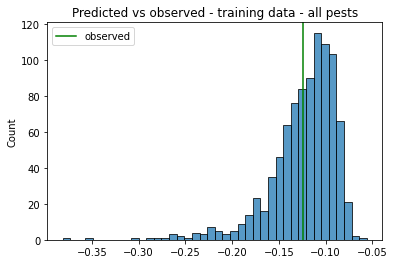

In [124]:
lr_all_pests_best_estimator = lr_all_pests_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_all_pests = model_selection.cross_val_score(
                    lr_all_pests_best_estimator,
                    X_train_all_pests,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_all_pests = lr_all_pests_best_estimator.predict(X_train_all_pests)
sns.histplot(lr_train_pred_all_pests).set(title='Predicted vs observed - training data - all pests')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: pests

In [125]:
lr_all_pests_test_pred = lr_all_pests_best_estimator.predict(X_test_all_pests)

print(f"Mean train CV score: {np.mean(lr_cv_scores_all_pests): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=lr_train_pred_all_pests): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_all_pests_test_pred): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=lr_train_pred_all_pests): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_all_pests_test_pred): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=lr_train_pred_all_pests, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_all_pests_test_pred, squared=False): .3f}")

Mean train CV score: -0.062
Train MAE:  0.045
Test MAE:  0.046
Train R-squared:  0.125
Test R-squared:  0.095
Train RMSE:  0.095
Test RMSE:  0.079


#### LRR: with features - plotting observed vs predicted - predictor: pests

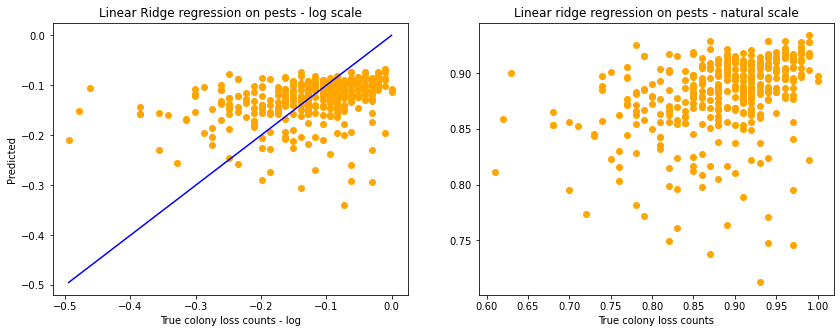

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, lr_all_pests_test_pred, c="orange")

p1 = max(max(lr_all_pests_test_pred), max(y_test))
p2 = min(min(lr_all_pests_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge regression on pests - log scale")

ax2.scatter(np.exp(y_test), np.exp(lr_all_pests_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Linear ridge regression on pests - natural scale')

plt.show()

#### LRR: with features - performance - predictor: pests

All metrics for linear ridge regression with pest data are better than the baseline, so this is a better model than the baseline. The difference between train and test data indicate that the model may be slightly underfit (e.g. the test RMSE is lower than the training RMSE. 

#### LRR: with features - fit model - predictor: varroa mites and regions

In [127]:
start = time.time()
lr_mites_regions = lr_grid_w_features.fit(X_train_mites_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.74 seconds


#### LRR: with features - CV score distribution - predictor: mites and regions

Elapsed time: 0.03 seconds


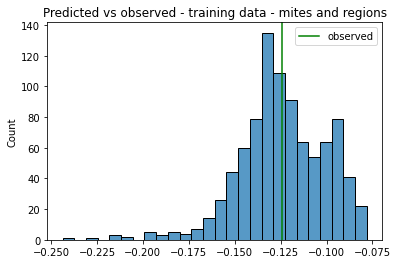

In [128]:
lr_mites_regions_best_estimator = lr_mites_regions.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_mites_regions = model_selection.cross_val_score(
                    lr_mites_regions_best_estimator,
                    X_train_mites_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_mites_regions = lr_mites_regions_best_estimator.predict(X_train_mites_regions)
sns.histplot(lr_train_pred_mites_regions).set(title='Predicted vs observed - training data - mites and regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: mites and regions

In [129]:
lr_test_pred_mites_regions = lr_mites_regions_best_estimator.predict(X_test_mites_regions)

print(f"Mean train CV score: {np.mean(lr_cv_scores_mites_regions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=lr_train_pred_mites_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_test_pred_mites_regions): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=lr_train_pred_mites_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_test_pred_mites_regions): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=lr_train_pred_mites_regions, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_test_pred_mites_regions, squared=False): .3f}")

Mean train CV score: -0.065
Train MAE:  0.048
Test MAE:  0.050
Train R-squared:  0.054
Test R-squared:  0.042
Train RMSE:  0.099
Test RMSE:  0.081


#### LRR: with features - plotting observed vs predicted - predictor: mites and regions

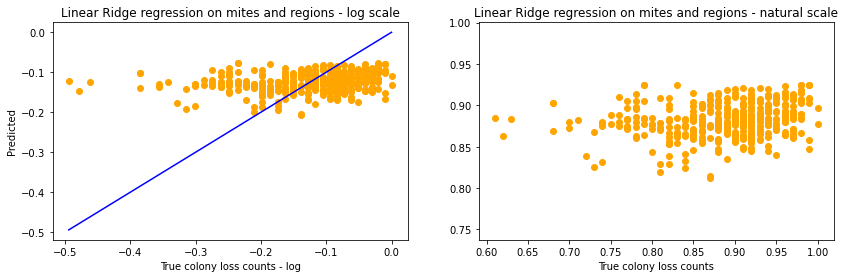

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, lr_test_pred_mites_regions, c="orange")

p1 = max(max(lr_test_pred_mites_regions), max(y_test))
p2 = min(min(lr_test_pred_mites_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge regression on mites and regions - log scale")

ax2.scatter(np.exp(y_test), np.exp(lr_test_pred_mites_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Linear Ridge regression on mites and regions - natural scale")
ax2.axis('equal')

plt.show()

#### LRR: with features - performance - predictor: mites and region data

Linear ridge regression on the varroa mite and region data together has mixed performance, as compared to the baseline. The model was originally optimized for mean absolute error, and performs about the same as the naive model on that metric. However, the R-squared is considerably better than the naive model, and the RMSE is marginally better. Test and train results for MAE are similar, indicating that the model is an accurate predictor.

#### LRR: with features - fit model - predictor: Patsy matrix of mites, pesticides, and regions

In [131]:
start = time.time()
lr_matrix_mod = lr_grid_w_features.fit(train_model_matrix, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.32 seconds


#### LRR: with features - CV score distribution - predictor: Patsy matrix of mites, pesticides, and regions

Elapsed time: 0.01 seconds


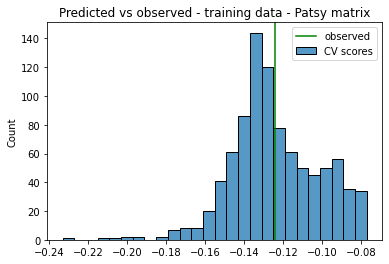

In [132]:
lr_matrix_best_estimator = lr_matrix_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_matrix = model_selection.cross_val_score(
                    lr_matrix_best_estimator,
                    train_model_matrix,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_matrix = lr_matrix_best_estimator.predict(train_model_matrix)
sns.histplot(lr_train_pred_matrix, label='CV scores').set(title='Predicted vs observed - training data - Patsy matrix')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: Patsy matrix of mites, pesticides, and regions

In [133]:
lr_test_pred_matrix = lr_matrix_best_estimator.predict(test_model_matrix)

print(f"Mean train CV score: {np.mean(lr_cv_scores_matrix): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=lr_train_pred_matrix): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_test_pred_matrix): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=lr_train_pred_matrix): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_test_pred_matrix): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=lr_train_pred_matrix, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_test_pred_matrix, squared=False): .3f}")

Mean train CV score: -0.065
Train MAE:  0.049
Test MAE:  0.049
Train R-squared:  0.058
Test R-squared:  0.042
Train RMSE:  0.099
Test RMSE:  0.081


#### LRR: with features - plotting observed vs predicted - predictor: Patsy matrix of mites, pesticides, and regions

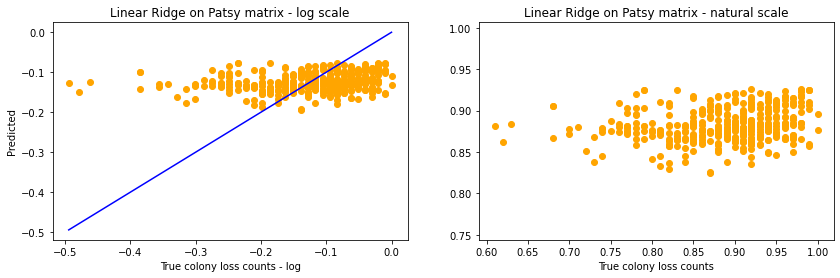

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, lr_test_pred_matrix, c="orange")

p1 = max(max(lr_test_pred_matrix), max(y_test))
p2 = min(min(lr_test_pred_matrix), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge on Patsy matrix - log scale")

ax2.scatter(np.exp(y_test), np.exp(lr_test_pred_matrix), c="orange")
ax2.set(xlabel='True colony loss counts', title="Linear Ridge on Patsy matrix - natural scale")
ax2.axis('equal')

plt.show()

#### LRR: with features - performance - predictor: Patsy matrix of mites, pesticides, and regions

All metrics for linear ridge regression with pest data are better than the baseline, so this is a better model than the baseline. 

### Linear Ridge regression - overall conclusions

The two best linear ridge regression models that provide value in their predictive abilities are the model of all the pest data, and the model using the Patsy matrix of varroa mites, pesticides, and region data. Of the two, the model using all the pest data as the predictor is the better model in terms of metric values. However, the Patsy model of varroa mite, pesticide, and region data has closer alignment between the training and testing sets, indicating that the consistency of the Patsy matrix as predictor may be higher.

## Random Forest regression

#### RF - create model object

In [135]:
rf_base_model = ensemble.RandomForestRegressor(random_state=42, bootstrap = True)

#### RF - create params object

In [136]:
rf_params = {'model__n_estimators': [50,100,150], 
             'model__max_depth': [None,4,8], 
             'model__min_samples_split': np.arange(2,20,5),
             'model__max_features': [0.3,0.5,1,'sqrt','auto'],
             'model__max_samples': [20]}

#### RF - create pipeline

In [137]:
rf_pipeline = pipeline.Pipeline(steps=[("model", rf_base_model)])

#### RF - create baseline grid

In [138]:
rf_baseline_grid = model_selection.GridSearchCV(
                        estimator=rf_pipeline,
                        param_grid=rf_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

### Random Forest - naive model

#### RF: naive - fit model

In [139]:
start = time.time()
rf_base_mod = rf_baseline_grid.fit(X_train_null, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 79.58 seconds


#### RF: naive - CV score distribution

Elapsed time: 0.54 seconds


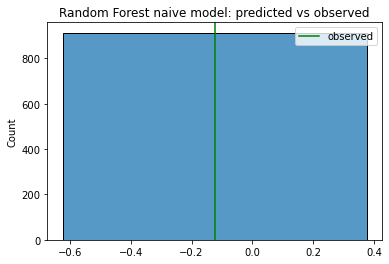

In [140]:
rf_base_best_estimator = rf_base_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores = model_selection.cross_val_score(
                    rf_base_best_estimator,
                    X_train_null,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_train_pred_naive = rf_base_best_estimator.predict(X_train_null)
sns.histplot(rf_train_pred_naive).set(title='Random Forest naive model: predicted vs observed')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()
plt.show()

#### RF: naive - train / test comparison

In [141]:
rf_test_pred_naive = rf_base_best_estimator.predict(X_test_null)

print(f"Mean train CV score: {np.mean(rf_cv_scores): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=rf_train_pred_naive): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_test_pred_naive): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=rf_train_pred_naive): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_test_pred_naive): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=rf_train_pred_naive, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_test_pred_naive, squared=False): .3f}")

Mean train CV score: -0.068
Train MAE:  0.051
Test MAE:  0.051
Train R-squared: -0.000
Test R-squared: -0.000
Train RMSE:  0.102
Test RMSE:  0.083


### Random Forest: with features

#### RF: with features - fit model - predictor: regions

In [142]:
start = time.time()
rf_regions_mod = rf_baseline_grid.fit(X_train_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 80.22 seconds


#### RF: with features - CV score distribution - predictor: regions

Elapsed time: 0.70 seconds


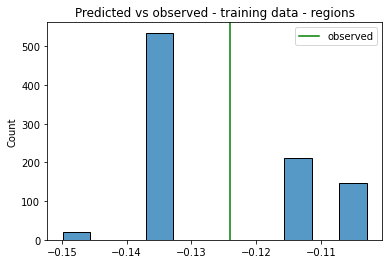

In [143]:
rf_regions_best_estimator = rf_regions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_regions = model_selection.cross_val_score(
                    rf_regions_best_estimator,
                    X_train_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_regions_train_pred = rf_regions_best_estimator.predict(X_train_regions)
sns.histplot(rf_regions_train_pred).set(title='Predicted vs observed - training data - regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: regions

In [144]:
rf_regions_test_pred = rf_regions_best_estimator.predict(X_test_regions)

print(f"Mean train CV score: {np.mean(rf_cv_scores_regions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=rf_regions_train_pred): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_regions_test_pred): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=rf_regions_train_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_regions_test_pred): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=rf_regions_train_pred, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_regions_test_pred, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.052
Test MAE:  0.053
Train R-squared:  0.028
Test R-squared:  0.028
Train RMSE:  0.100
Test RMSE:  0.082


#### RF: with features - plotting observed vs predicted - predictor: regions

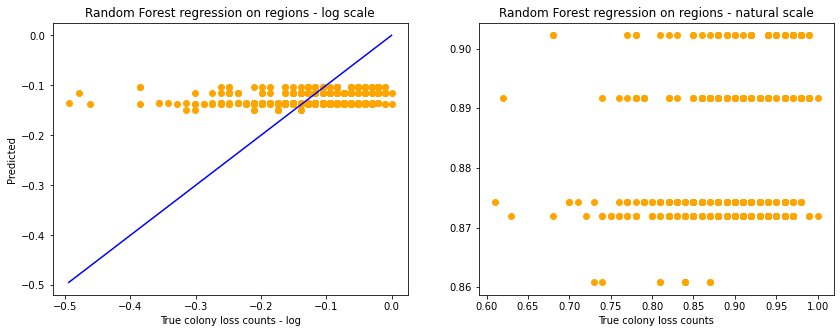

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, rf_regions_test_pred, c="orange")

p1 = max(max(rf_regions_test_pred), max(y_test))
p2 = min(min(rf_regions_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest regression on regions - log scale")

ax2.scatter(np.exp(y_test), np.exp(rf_regions_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Random Forest regression on regions - natural scale')

plt.show()

#### RF: with features - performance - predictor: regions

The metric that was optimized for, mean absolute error, is worse for random forest regression using region data than it is for naive data. The R-squared value is a little better, and the RMSE is roughly the same.

#### RF: with features - fit model - predictor: subregions

In [146]:
start = time.time()
rf_subregions_mod = rf_baseline_grid.fit(X_train_subregions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 82.38 seconds


#### RF: with features - CV score distribution - predictor: subregions

Elapsed time: 0.67 seconds


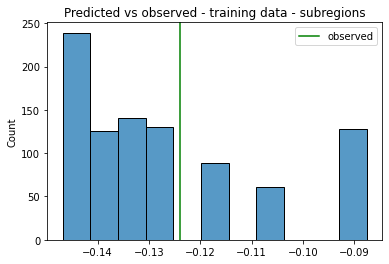

In [147]:
rf_subregions_best_estimator = rf_subregions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_subregions = model_selection.cross_val_score(
                    rf_subregions_best_estimator,
                    X_train_subregions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_subregions_train_pred = rf_subregions_best_estimator.predict(X_train_subregions)
sns.histplot(rf_subregions_train_pred).set(title='Predicted vs observed - training data - subregions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: subregions

In [148]:
rf_subregions_test_pred = rf_subregions_best_estimator.predict(X_test_subregions)

print(f"Mean train CV score: {np.mean(rf_cv_scores_subregions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=rf_subregions_train_pred): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_subregions_test_pred): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=rf_subregions_train_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_subregions_test_pred): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=rf_subregions_train_pred, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_subregions_test_pred, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.052
Test MAE:  0.055
Train R-squared:  0.047
Test R-squared:  0.074
Train RMSE:  0.099
Test RMSE:  0.080


#### RF: with features - plotting observed vs predicted - predictor: subregions

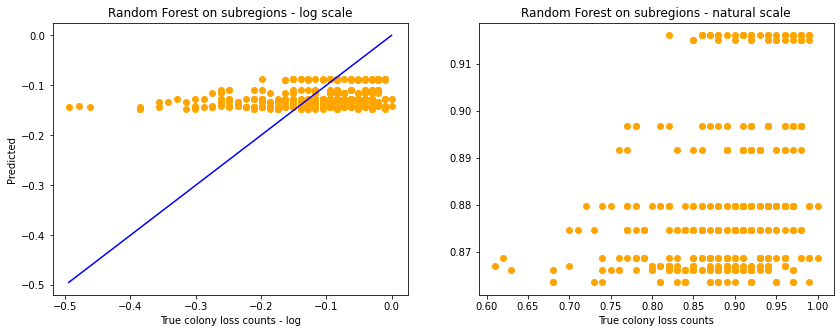

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, rf_subregions_test_pred, c="orange")

p1 = max(max(rf_subregions_test_pred), max(y_test))
p2 = min(min(rf_subregions_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest on subregions - log scale")

ax2.scatter(np.exp(y_test), np.exp(rf_subregions_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Random Forest on subregions - natural scale')

plt.show()

#### RF: with features - performance - predictor: subregions

The random forest regressor with subregion data performs similarly to the same regressor with region data: worse than the naive model for the MAE metric, better for R-squared, and roughly the same for RMSE. 

#### RF: with features - fit model - predictor: pests

In [150]:
start = time.time()
rf_all_pests_mod = rf_baseline_grid.fit(X_train_all_pests, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 85.65 seconds


#### RF: with features - CV score distribution - predictor: pests

Elapsed time: 0.79 seconds


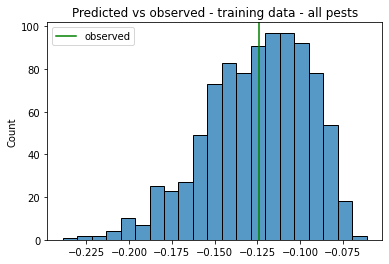

In [151]:
rf_all_pests_best_estimator = rf_all_pests_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_all_pests = model_selection.cross_val_score(
                    rf_all_pests_best_estimator,
                    X_train_all_pests,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_all_pests_train_pred = rf_all_pests_best_estimator.predict(X_train_all_pests)
sns.histplot(rf_all_pests_train_pred).set(title='Predicted vs observed - training data - all pests')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: pests

In [152]:
rf_all_pests_test_pred = rf_all_pests_best_estimator.predict(X_test_all_pests)

print(f"Mean train CV score: {np.mean(rf_cv_scores_all_pests): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=rf_all_pests_train_pred): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_all_pests_test_pred): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=rf_all_pests_train_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_all_pests_test_pred): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=rf_all_pests_train_pred, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_all_pests_test_pred, squared=False): .3f}")

Mean train CV score: -0.063
Train MAE:  0.045
Test MAE:  0.047
Train R-squared:  0.150
Test R-squared:  0.132
Train RMSE:  0.094
Test RMSE:  0.077


#### RF: with features - plotting observed vs predicted - predictor: pests

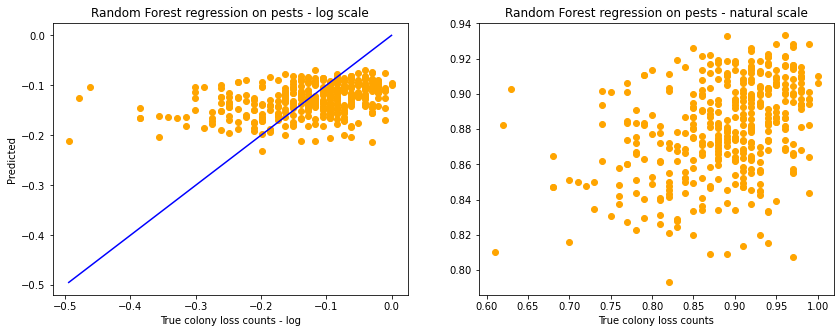

In [153]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, rf_all_pests_test_pred, c="orange")

p1 = max(max(rf_all_pests_test_pred), max(y_test))
p2 = min(min(rf_all_pests_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest regression on pests - log scale")

ax2.scatter(np.exp(y_test), np.exp(rf_all_pests_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Random Forest regression on pests - natural scale')

plt.show()

#### RF: with features - performance - predictor: pest data

The random forest regressor with all pest data performs better than the naive model by all metrics. The RMSE comparison between the train and test sets shows slight underfitting, while the commparison on MAE shows slight overfitting. Given that the metrics show the opposite in terms of fit, and both are slight, this seems like a promising model. 

#### RF: with features - fit model - predictor: mites and regions

In [154]:
start = time.time()
rf_mites_regions = rf_baseline_grid.fit(X_train_mites_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 82.64 seconds


#### RF: with features - CV score distribution - predictor: mites and regions

Elapsed time: 0.55 seconds


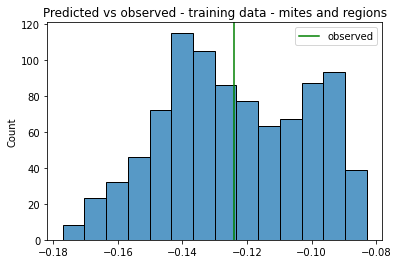

In [155]:
rf_mites_regions_best_estimator = rf_mites_regions.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_mites_regions = model_selection.cross_val_score(
                    rf_mites_regions_best_estimator,
                    X_train_mites_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_rf_mites_regions = rf_mites_regions_best_estimator.predict(X_train_mites_regions)
sns.histplot(train_pred_rf_mites_regions).set(title='Predicted vs observed - training data - mites and regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: mites and regions

In [156]:
test_pred_rf_mites_regions = rf_mites_regions_best_estimator.predict(X_test_mites_regions)

print(f"Mean train CV score: {np.mean(rf_cv_scores_mites_regions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=train_pred_rf_mites_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_rf_mites_regions): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=train_pred_rf_mites_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_rf_mites_regions): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=train_pred_rf_mites_regions, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_rf_mites_regions, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.050
Test MAE:  0.051
Train R-squared:  0.065
Test R-squared:  0.013
Train RMSE:  0.098
Test RMSE:  0.083


#### RF: with features - plotting observed vs predicted - predictor: mites and regions

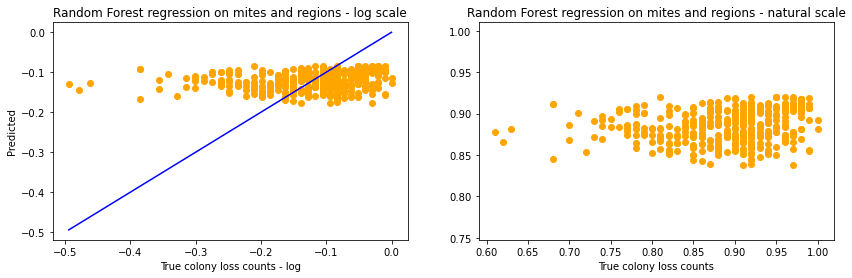

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, test_pred_rf_mites_regions, c="orange")

p1 = max(max(test_pred_rf_mites_regions), max(y_test))
p2 = min(min(test_pred_rf_mites_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest regression on mites and regions - log scale")

ax2.scatter(np.exp(y_test), np.exp(test_pred_rf_mites_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Random Forest regression on mites and regions - natural scale")
ax2.axis('equal')

plt.show()

#### RF: with features - performance - predictor: mites and regions

The random forest regressor with varroa mite and region data combined performs similarly to the same regressor with region data: worse than the naive model for the MAE metric, better for R-squared, and roughly the same for RMSE. This indicates that the addition of the varroa mite data to region data doesn't improve the model as I would have anticipated. 

#### RF: with features - fit model - predictor: Patsy matrix

In [158]:
start = time.time()
rf_matrix_train = rf_baseline_grid.fit(train_model_matrix, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 77.26 seconds


#### RF: with features - CV score distribution - predictor: Patsy matrix

Elapsed time: 0.69 seconds


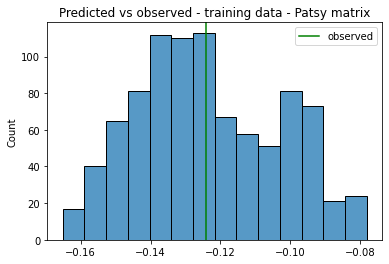

In [159]:
rf_matrix_best_estimator = rf_matrix_train.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_matrix = model_selection.cross_val_score(
                    rf_matrix_best_estimator,
                    train_model_matrix,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_train_pred_matrix = rf_matrix_best_estimator.predict(train_model_matrix)
sns.histplot(rf_train_pred_matrix).set(title='Predicted vs observed - training data - Patsy matrix')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: Patsy matrix

In [160]:
rf_test_pred_matrix = rf_matrix_best_estimator.predict(test_model_matrix)

print(f"Mean train CV score: {np.mean(rf_cv_scores_matrix): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=rf_train_pred_matrix): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_test_pred_matrix): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=rf_train_pred_matrix): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_test_pred_matrix): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=rf_train_pred_matrix, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_test_pred_matrix, squared=False): .3f}")

Mean train CV score: -0.066
Train MAE:  0.050
Test MAE:  0.051
Train R-squared:  0.066
Test R-squared:  0.038
Train RMSE:  0.098
Test RMSE:  0.081


#### RF: with features - plotting observed vs predicted - predictor: Patsy matrix

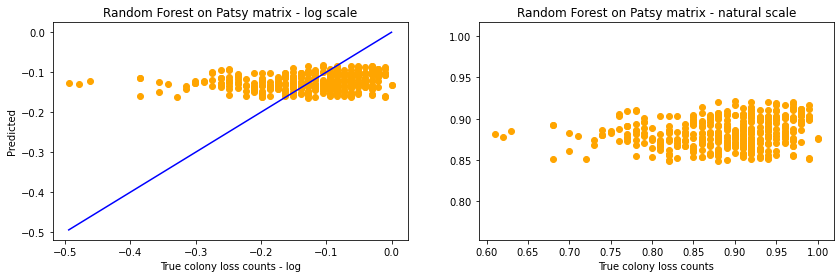

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, rf_test_pred_matrix, c="orange")

p1 = max(max(rf_test_pred_matrix), max(y_test))
p2 = min(min(rf_test_pred_matrix), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest on Patsy matrix - log scale")

ax2.scatter(np.exp(y_test), np.exp(rf_test_pred_matrix), c="orange")
ax2.set(xlabel='True colony loss counts', title="Random Forest on Patsy matrix - natural scale")
ax2.axis('equal')

plt.show()

#### RF: with features - performance - predictor: Patsy matrix

The random forest regressor with a Patsy matrix of varroa mite, pesticide, and region data combined only performs better than the naive model on the R-squared metric. The other two metrics are approximately the same as the baseline model. 

### Random Forest regression - overall conclusions

The one model that stands out random forest regression is the one built with pests as the predictive fields. In comparison to the models built with linear ridge regression, it falls in the middle of the two stand outs there, in terms of metrics, performing slightly better than the Patsy matrix and slightly worse than the linear ridge pest model. The training and test data sets align about as well as the pest data for linear ridge. 

## Support Vector regression

#### SV - create model object

In [162]:
sv_base_model = svm.SVR(kernel="poly", degree=3, epsilon=0.1, coef0=1)

#### SV - create params object

In [163]:
sv_params = {'model__C': [0.1, 1, 10, 100, 1000], 
             'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto']}

#### SV - create pipeline

In [164]:
sv_pipeline = pipeline.Pipeline(steps=[("model", sv_base_model)])

#### SV - create baseline grid

In [165]:
sv_baseline_grid = model_selection.GridSearchCV(
                        estimator=sv_pipeline,
                        param_grid=sv_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

### Support Vector: naive model

#### SV: naive - fit model

In [166]:
start = time.time()
sv_base_mod = sv_baseline_grid.fit(X_train_null, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 0.90 seconds


#### SV: naive - CV score distribution

Elapsed time: 0.03 seconds


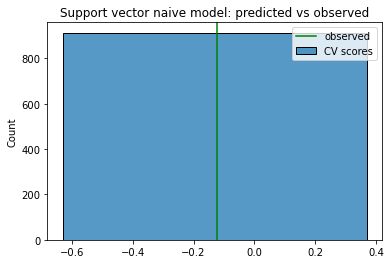

In [167]:
sv_base_best_estimator = sv_base_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores = model_selection.cross_val_score(
                    sv_base_best_estimator,
                    X_train_null,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

sv_naive_train_pred = sv_base_best_estimator.predict(X_train_null)
sns.histplot(sv_naive_train_pred, label='CV scores').set(title='Support vector naive model: predicted vs observed')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()
plt.show()

#### SV: naive - train / test comparison

In [168]:
sv_naive_test_pred = sv_base_best_estimator.predict(X_test_null)

print(f"Mean train CV score: {np.mean(sv_cv_scores): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=sv_naive_train_pred): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=sv_naive_test_pred): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=sv_naive_train_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=sv_naive_test_pred): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=sv_naive_train_pred, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=sv_naive_test_pred, squared=False): .3f}")

Mean train CV score: -0.070
Train MAE:  0.058
Test MAE:  0.057
Train R-squared: -0.004
Test R-squared: -0.007
Train RMSE:  0.102
Test RMSE:  0.083


### Support Vector: with features

#### SV: with features - fit model - predictor: regions

In [169]:
start = time.time()
sv_regions_mod = sv_baseline_grid.fit(X_train_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 1.11 seconds


#### SV: with features - CV score distribution - predictor: regions

Elapsed time: 0.05 seconds


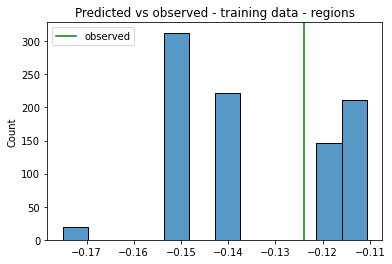

In [170]:
sv_regions_best_estimator = sv_regions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_regions = model_selection.cross_val_score(
                    sv_regions_best_estimator,
                    X_train_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_regions_sv = sv_regions_best_estimator.predict(X_train_regions)
sns.histplot(train_pred_regions_sv).set(title='Predicted vs observed - training data - regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: regions

In [171]:
test_pred_sv_regions = sv_regions_best_estimator.predict(X_test_regions)

print(f"Mean train CV score: {np.mean(sv_cv_scores_regions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=train_pred_regions_sv): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_regions): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=train_pred_regions_sv): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_regions): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=train_pred_regions_sv, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_regions, squared=False): .3f}")

Mean train CV score: -0.070
Train MAE:  0.057
Test MAE:  0.057
Train R-squared:  0.023
Test R-squared:  0.012
Train RMSE:  0.101
Test RMSE:  0.083


#### SV: with features - plotting observed vs predicted - predictor: regions

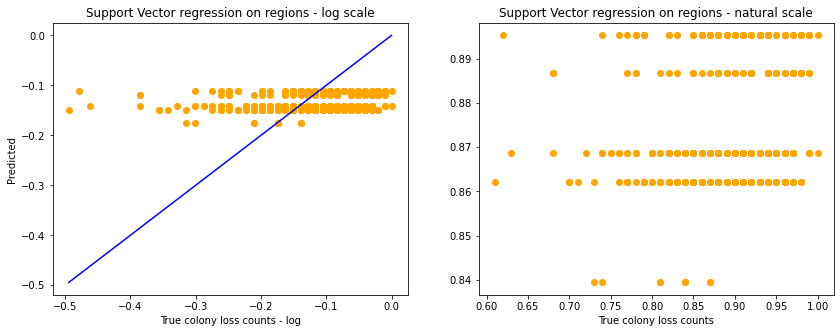

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, test_pred_sv_regions, c="orange")

p1 = max(max(test_pred_sv_regions), max(y_test))
p2 = min(min(test_pred_sv_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector regression on regions - log scale")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector regression on regions - natural scale")

plt.show()

#### SV: with features - performance - predictor: regions

The support vector regression model with region as the predictor only performs well on the R-squared metric, but performs the same as the naive model for MAE and RMSE. 

#### SV: with features - fit model - predictor: subregions

In [173]:
start = time.time()
sv_subregions_mod = sv_baseline_grid.fit(X_train_subregions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 1.28 seconds


#### SV: with features - CV score distribution - predictor: subregions

Elapsed time: 0.06 seconds


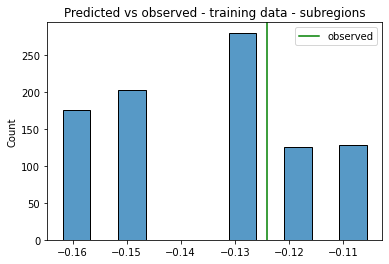

In [174]:
sv_subregions_best_estimator = sv_subregions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_subregions = model_selection.cross_val_score(
                    sv_subregions_best_estimator,
                    X_train_subregions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_subregions_sv = sv_subregions_best_estimator.predict(X_train_subregions)
sns.histplot(train_pred_subregions_sv).set(title='Predicted vs observed - training data - subregions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: subregions

In [175]:
test_pred_sv_subregions = sv_subregions_best_estimator.predict(X_test_subregions)

print(f"Mean train CV score: {np.mean(sv_cv_scores_subregions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=train_pred_subregions_sv): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_subregions): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=train_pred_subregions_sv): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_subregions): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=train_pred_subregions_sv, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_subregions, squared=False): .3f}")

Mean train CV score: -0.070
Train MAE:  0.057
Test MAE:  0.058
Train R-squared:  0.034
Test R-squared:  0.039
Train RMSE:  0.100
Test RMSE:  0.081


#### SV: with features - plotting observed vs predicted - predictor: subregions

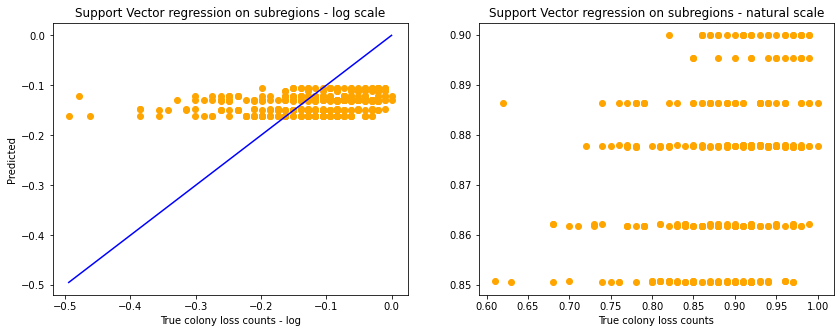

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, test_pred_sv_subregions, c="orange")

p1 = max(max(test_pred_sv_subregions), max(y_test))
p2 = min(min(test_pred_sv_subregions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector regression on subregions - log scale")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_subregions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector regression on subregions - natural scale")

plt.show()

#### SV: with features - performance - predictor: subregions

Similar to the support vector regression model with region data, subregion data only performs well on the R-squared metric, but performs the same as the naive model for MAE and RMSE.

#### SV: with features - fit model - predictor: all pests

In [177]:
start = time.time()
sv_all_pests_mod = sv_baseline_grid.fit(X_train_all_pests, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 13.18 seconds


#### SV: with features - CV score distribution - predictor: all pests

Elapsed time: 0.10 seconds


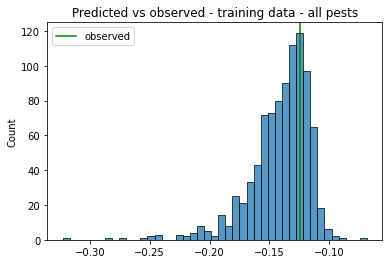

In [178]:
sv_all_pests_best_estimator = sv_all_pests_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_all_pests = model_selection.cross_val_score(
                    sv_all_pests_best_estimator,
                    X_train_all_pests,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_all_pests_sv = sv_all_pests_best_estimator.predict(X_train_all_pests)
sns.histplot(train_pred_all_pests_sv).set(title='Predicted vs observed - training data - all pests')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: all pests

In [179]:
test_pred_sv_all_pests = sv_all_pests_best_estimator.predict(X_test_all_pests)

print(f"Mean train CV score: {np.mean(sv_cv_scores_all_pests): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=train_pred_all_pests_sv): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_all_pests): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=train_pred_all_pests_sv): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_all_pests): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=train_pred_all_pests_sv, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_all_pests, squared=False): .3f}")

Mean train CV score: -0.068
Train MAE:  0.059
Test MAE:  0.058
Train R-squared:  0.087
Test R-squared:  0.056
Train RMSE:  0.097
Test RMSE:  0.081


#### SV: with features - plotting observed vs predicted - predictor: all pests

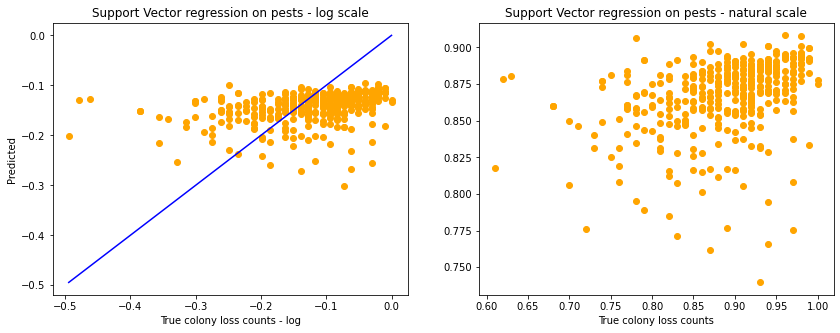

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, test_pred_sv_all_pests, c="orange")

p1 = max(max(test_pred_sv_all_pests), max(y_test))
p2 = min(min(test_pred_sv_all_pests), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector regression on pests - log scale")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_all_pests), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector regression on pests - natural scale")

plt.show()

#### SV: with features - performance - predictor: pests

The support vector model performs worse than the baseline on pests for MAE, better for the R-squared metric, and slightly better for RMSE. The pest model had some of the best performance in the other two regression models, so I would have expected better results here as well. 

#### SV: with features - fit model - predictor: mites and regions

In [181]:
start = time.time()
sv_mites_regions = sv_baseline_grid.fit(X_train_mites_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 5.86 seconds


#### SV: with features - CV score distribution - predictor: mites and regions

Elapsed time: 0.06 seconds


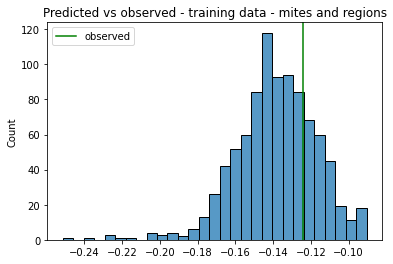

In [182]:
sv_mites_regions_best_estimator = sv_mites_regions.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_mites_regions = model_selection.cross_val_score(
                    sv_mites_regions_best_estimator,
                    X_train_mites_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_sv_mites_regions = sv_mites_regions_best_estimator.predict(X_train_mites_regions)
sns.histplot(train_pred_sv_mites_regions).set(title='Predicted vs observed - training data - mites and regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: mites and regions

In [183]:
test_pred_sv_mites_regions = sv_mites_regions_best_estimator.predict(X_test_mites_regions)

print(f"Mean train CV score: {np.mean(test_pred_sv_mites_regions): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=train_pred_sv_mites_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_mites_regions): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=train_pred_sv_mites_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_mites_regions): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=train_pred_sv_mites_regions, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_mites_regions, squared=False): .3f}")

Mean train CV score: -0.139
Train MAE:  0.056
Test MAE:  0.059
Train R-squared:  0.033
Test R-squared:  0.008
Train RMSE:  0.100
Test RMSE:  0.083


#### SV: with features - plotting observed vs predicted - predictor: mites and regions

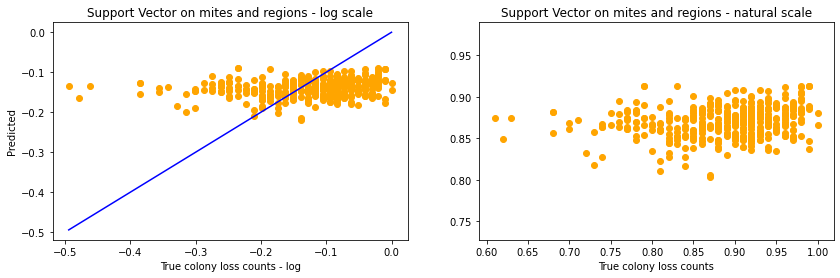

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, test_pred_sv_mites_regions, c="orange")

p1 = max(max(test_pred_sv_mites_regions), max(y_test))
p2 = min(min(test_pred_sv_mites_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector on mites and regions - log scale")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_mites_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector on mites and regions - natural scale")
ax2.axis('equal')

plt.show()

#### SV: with features - performance - predictor: mites and regions

Like the region and subregion models, adding varroa mite data did not make a significant improvement to the quality of results. In fact, R-squared was slightly worse. Further, the difference in data between train and test sets show that this isn't a well-aligned model.

#### SV: with features - fit model - predictor: Patsy matrix

In [185]:
start = time.time()
sv_matrix_train = sv_baseline_grid.fit(train_model_matrix, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 17.49 seconds


#### SV: with features - CV score distribution - predictor: Patsy matrix

Elapsed time: 0.04 seconds


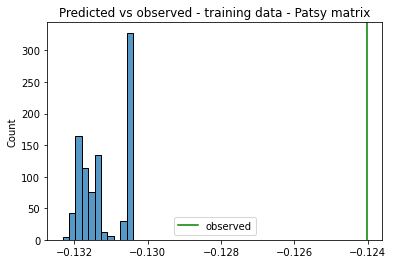

In [186]:
sv_matrix_best_estimator = sv_matrix_train.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_matrix = model_selection.cross_val_score(
                    sv_matrix_best_estimator,
                    train_model_matrix,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

sv_train_pred_matrix = sv_matrix_best_estimator.predict(train_model_matrix)
sns.histplot(sv_train_pred_matrix).set(title='Predicted vs observed - training data - Patsy matrix')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: Patsy matrix

In [187]:
sv_test_pred_matrix = sv_matrix_best_estimator.predict(test_model_matrix)

print(f"Mean train CV score: {np.mean(sv_cv_scores_matrix): .3f}")

print(f"Train MAE: {metrics.median_absolute_error(y_true=y_train, y_pred=sv_train_pred_matrix): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=sv_test_pred_matrix): .3f}")
print(f"Train R-squared: {metrics.r2_score(y_true=y_train, y_pred=sv_train_pred_matrix): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=sv_test_pred_matrix): .3f}")
print(f"Train RMSE: {metrics.mean_squared_error(y_true=y_train, y_pred=sv_train_pred_matrix, squared=False): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=sv_test_pred_matrix, squared=False): .3f}")

Mean train CV score: -0.070
Train MAE:  0.058
Test MAE:  0.057
Train R-squared: -0.003
Test R-squared: -0.007
Train RMSE:  0.102
Test RMSE:  0.083


#### SV: with features - plotting observed vs predicted - predictor: Patsy matrix

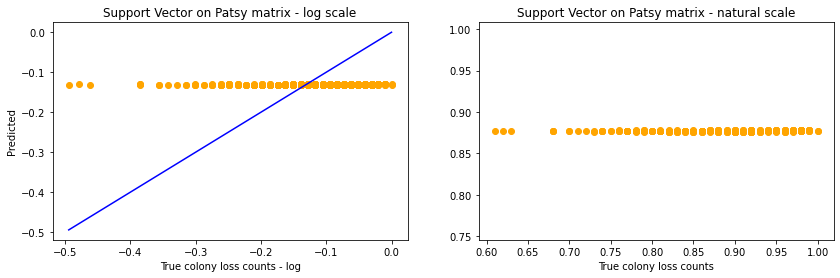

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, sv_test_pred_matrix, c="orange")

p1 = max(max(sv_test_pred_matrix), max(y_test))
p2 = min(min(sv_test_pred_matrix), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector on Patsy matrix - log scale")

ax2.scatter(np.exp(y_test), np.exp(sv_test_pred_matrix), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector on Patsy matrix - natural scale")
ax2.axis('equal')

plt.show()

#### SV: with features - performance - predictor: Patsy matrix

The metrics for a Patsy matrix of varroa mites, pesticides, and region data was almost identical to the metrics yielded by the baseline model. In fact, they are so similar that I doublechecked that I didn't have an entry error.

### Support Vector regression - conclusions

Overall, the support vector regression model performed poorly. I don't know if poor performance is why support vector is seldom in use anymore, but as a novice to data science, I found it surprising how clear it is that this regression model is lower quality as compared to the other two.